ANN for NARX

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from scipy.io import loadmat
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, Normalizer
from sklearn.linear_model import LinearRegression

out = loadmat(f'UnbalancedDisk-sim-data.mat') 
x = out['ulist'][0,:]
y = out['ylist'][0,:] 
x=x[0:3000]
y=y[0:3000]

In [2]:
na, nb = 2, 2
ulist = x
ylist = y
def make_training_data(ulist,ylist,na,nb):
    Xdata = []
    Ydata = []
    
    for k in range(max(na,nb),len(ulist)): 
        Xdata.append(np.concatenate([ulist[k-nb:k],ylist[k-na:k]])) 
        Ydata.append(ylist[k])
    return np.array(Xdata), np.array(Ydata)

Xdata, Ydata = make_training_data(ulist,ylist, na, nb)

from sklearn.model_selection import train_test_split 
Xtrain, Xval, Ytrain, Yval = train_test_split(Xdata, Ydata) 

In [3]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.lay1 = nn.Linear(4,32).double()                                    
        self.lay2 = nn.Linear(32,1).double() 
    
    def forward(self,u):
        x1 = torch.sigmoid(self.lay1(u)) 
        y = self.lay2(x1)[:,0] 
        return y

In [4]:
X_data=torch.from_numpy(Xtrain)
Y_data=torch.from_numpy(Ytrain)
X_val=torch.from_numpy(Xval)
Y_val=torch.from_numpy(Yval)

In [5]:
model = Network()
print(model)
parameters = list(model.parameters())
print(parameters) 

optimizer = torch.optim.Adam(model.parameters(),lr=1e-4) 
for epoch in range(20000):
    Loss = torch.mean((model(X_data)-Y_data)**2) 
    optimizer.zero_grad()
    Loss.backward() 
    optimizer.step() 
    if epoch%500==0: 
       print(f'epoch={epoch} Loss={Loss}')

Network(
  (lay1): Linear(in_features=4, out_features=32, bias=True)
  (lay2): Linear(in_features=32, out_features=1, bias=True)
)
[Parameter containing:
tensor([[ 0.2783, -0.0892, -0.1223, -0.3121],
        [ 0.0400,  0.4156,  0.3294, -0.1366],
        [ 0.1079, -0.0151,  0.1092,  0.4114],
        [-0.2559,  0.0867, -0.2886,  0.2225],
        [ 0.1855, -0.2941, -0.0444, -0.0555],
        [-0.0824,  0.3733,  0.3260, -0.1187],
        [-0.2833,  0.2066, -0.4341,  0.0417],
        [ 0.3339,  0.1503,  0.4304,  0.4165],
        [-0.1180,  0.4197, -0.1462,  0.0343],
        [-0.1389, -0.2544, -0.0652,  0.3925],
        [ 0.4727, -0.0956, -0.4645,  0.0929],
        [ 0.2653, -0.0301,  0.3977, -0.3144],
        [-0.3950, -0.3300,  0.0142,  0.1185],
        [ 0.3607,  0.4246, -0.0900,  0.4081],
        [ 0.3263, -0.3383,  0.2405, -0.0931],
        [-0.1715, -0.0157, -0.0799, -0.4560],
        [ 0.2614, -0.3660,  0.0026,  0.4243],
        [ 0.2837, -0.3542,  0.0150, -0.4397],
        [ 0.1737, 

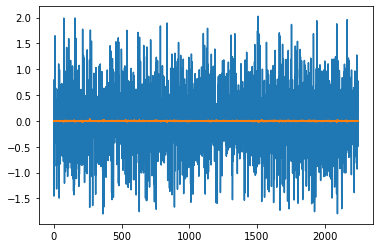

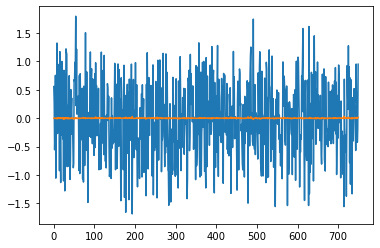

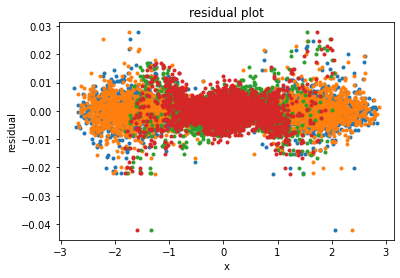

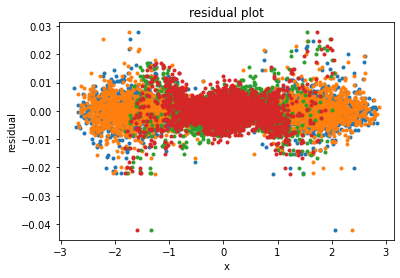

In [16]:
with torch.no_grad(): 
      plt.plot(model(X_data),label='predicted')
      plt.plot(model(X_data)-Y_data,label='error')  
      plt.show()
      
      plt.plot(model(X_val),label='predicted')
      plt.plot(model(X_val)-Y_val,label='error')     
      plt.show()
    
      plt.title('residual plot')
      plt.xlabel('x')
      plt.ylabel('residual')
      plt.plot(X_data,Y_data-model(X_data),'.')
      plt.show()
        
      plt.title('residual plot')
      plt.xlabel('x')
      plt.ylabel('residual')
      plt.plot(X_data,Y_data-model(X_data),'.')
      plt.show()